# Breadth First Search

*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

## Barabasi-Albert graphs

Each new node is connected to 5 previous ones, so the total number of edges is $5n$.

In [24]:
import networkx as nx

ba = nx.barabasi_albert_graph(100, 5)

In [23]:
ba.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99))

Here's the implementation of BFS in NetworkX.

[Source code for bfs_edges](https://networkx.org/documentation/stable/_modules/networkx/algorithms/traversal/breadth_first_search.html#bfs_edges)



In [30]:
nodes = set()
for edge in nx.bfs_edges(ba, 0):
    nodes.update(edge)
    
len(nodes)

100

And here's the version in [Think Complexity](https://greenteapress.com/complexity2/html/thinkcomplexity2004.html#sec31)

In [41]:
from collections import deque

def reachable_nodes_bfs(G, start):
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

In [56]:
nodes = reachable_nodes_bfs(ba, 0)
len(nodes)

100

We can confirm that it runs in time proportional to $n$.

1024 0.03999999999999915
2048 0.129999999999999
4096 0.5
8192 2.190000000000005


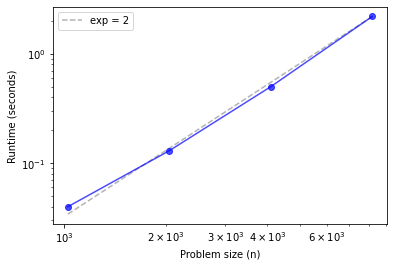

In [57]:
from order import run_timing_test, plot_timing_test

def test_bfs_ba_graph(n):
    ba = nx.barabasi_albert_graph(n, 5)
    nodes = reachable_nodes_bfs(ba, 0)

ns, ts = run_timing_test(test_bfs_ba_graph)
plot_timing_test(ns, ts, exp=2)

In an Erdos Renyi graph, each possible edge has the same probability of existing, so the total number of edges is proportional to $n^2$.

The time is takes to create the graph is proportional to $n^2$, but in a good implementation, it depends on the number of edges that actually exist, rather than enumerating all possible edges.

[fast_pnp_random_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.fast_gnp_random_graph.html)

[Efficient generation of large random networks](http://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdf)

1024 0.07000000000000028
2048 0.26000000000000156
4096 1.0999999999999979


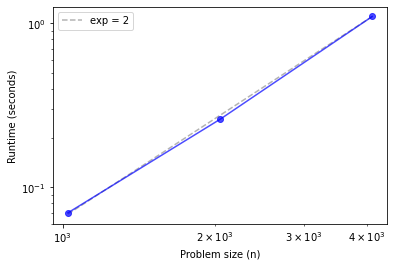

In [58]:
def test_fast_gnp_random_graph(n):
    ba = nx.fast_gnp_random_graph(n, p=0.1)

ns, ts = run_timing_test(test_fast_gnp_random_graph)
plot_timing_test(ns, ts, exp=2)

With a graph like this, we expect BFS to be proportional to $n^2$.
But it's not easy to confirm with the timing tools we're using.

1024 0.46000000000000085
2048 3.8800000000000026


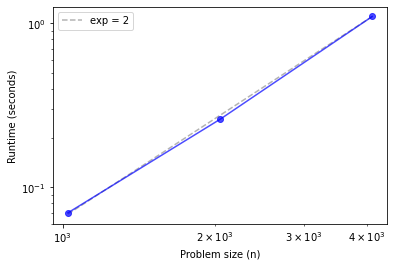

In [59]:
def test_bfs_gnp_graph(n):
    ba = nx.fast_gnp_random_graph(n, p=0.1)
    nodes = reachable_nodes_bfs(ba, 0)

ns2, ts2 = run_timing_test(test_bfs_gnp_graph)
plot_timing_test(ns, ts, exp=2)

If you do a search for "python breadth first search", a large majority of the implementations you find contain at least one performance error, so their asymptotic time requirement is not $O(n+m)$.

For each of the implementations below, see if you can spot the performance error (if any).

[Source](https://eddmann.com/posts/depth-first-search-and-breadth-first-search-in-python)

In [ ]:
def bfs(graph, start):
    visited, queue = set(), [start]

    while queue:
        vertex = queue.pop(0)

        if vertex not in visited:
            visited.add(vertex)
            queue.extend(graph[vertex] - visited)

    return visited

[Source](https://jeremykun.com/2013/01/22/depth-and-breadth-first-search/)

In [ ]:
from collections import deque
 
def breadthFirst(startingNode, soughtValue):
    visitedNodes = set()
    queue = deque([startingNode])

    while len(queue) > 0:
        node = queue.pop()
        if node in visitedNodes:
            continue

        visitedNodes.add(node)
        if node.value == soughtValue:
            return True

        for n in node.adjacentNodes:
            if n not in visitedNodes:
                queue.appendleft(n)
                
    return False

[Source](https://pythoninwonderland.wordpress.com/2017/03/18/how-to-implement-breadth-first-search-in-python/)

In [ ]:
def bfs_connected_component(graph, start):

    # keep track of all visited nodes
    explored = []

    # keep track of nodes to be checked
    queue = [start]

 

    # keep looping until there are nodes still to be checked
    while queue:

        # pop shallowest node (first node) from queue
        node = queue.pop(0)

        if node not in explored:

            # add node to list of checked nodes
            explored.append(node)
            neighbours = graph[node]

            # add neighbours of node to queue
            for neighbour in neighbours:
                queue.append(neighbour)

    return explored

[Source](https://codereview.stackexchange.com/questions/135156/bfs-implementation-in-python-3)

In [ ]:
def bfs(graph, root):

    visited, queue = [], [root]

    while queue:
        vertex = queue.pop(0)

        for w in graph[vertex]:
            if w not in visited:
                visited.append(w)
                queue.append(w)

[Source](https://www.geeksforgeeks.org/breadth-first-search-or-bfs-for-a-graph/)

In [ ]:
def BFS(self, s):
        # Mark all the vertices as not visited
        visited = [False]*(len(self.graph))

        # Create a queue for BFS
        queue = []

        # Mark the source node as visited and enqueue it
        queue.append(s)
        visited[s] = True

        while queue:
            # Dequeue a vertex from queue and print it
            s = queue.pop(0)
            print s,

            # Get all adjacent vertices of the dequeued
            # vertex s. If a adjacent has not been visited,
            # then mark it visited and enqueue it

            for i in self.graph[s]:
                if visited[i] == False:
                    queue.append(i)
                    visited[i] = True

[Source](http://interactivepython.org/runestone/static/pythonds/Graphs/ImplementingBreadthFirstSearch.html)

In [2]:
# from pythonds.graphs import Graph, Vertex
# from pythonds.basic import Queue

def bfs(g,start):
    start.setDistance(0)
    start.setPred(None)
    vertQueue = Queue()
    vertQueue.enqueue(start)

    while (vertQueue.size() > 0):
        currentVert = vertQueue.dequeue()

        for nbr in currentVert.getConnections():

            if (nbr.getColor() == 'white'):
                nbr.setColor('gray')
                nbr.setDistance(currentVert.getDistance() + 1)
                nbr.setPred(currentVert)
                vertQueue.enqueue(nbr)

        currentVert.setColor('black')

[Source](https://code.activestate.com/recipes/576675-bfs-breadth-first-search-graph-traversal/)

In [5]:
# a sample graph
graph = {'A': ['B', 'C','E'],
             'B': ['A','C', 'D'],
             'C': ['D'],
             'D': ['C'],
             'E': ['F','D'],
             'F': ['C']}

In [7]:
class MyQUEUE: # just an implementation of a queue

    def __init__(self):
        self.holder = []
        
    def enqueue(self,val):
        self.holder.append(val)
        
    def dequeue(self):
        val = None
        try:
            val = self.holder[0]
            if len(self.holder) == 1:
                self.holder = []
            else:
                self.holder = self.holder[1:]    
        except:
            pass
            
        return val    
        
    def IsEmpty(self):
        result = False
        if len(self.holder) == 0:
            result = True
        return result

In [8]:
path_queue = MyQUEUE() # now we make a queue

In [10]:
def BFS(graph,start,end,q):

    temp_path = [start]

    q.enqueue(temp_path)

    while q.IsEmpty() == False:
        tmp_path = q.dequeue()
        last_node = tmp_path[len(tmp_path)-1]
        print(tmp_path)
        if last_node == end:
            print("VALID_PATH : ",tmp_path)
        for link_node in graph[last_node]:
            if link_node not in tmp_path:
                new_path = []
                new_path = tmp_path + [link_node]
                q.enqueue(new_path)

In [11]:
BFS(graph,"A","D",path_queue)

['A']
['A', 'B']
['A', 'C']
['A', 'E']
['A', 'B', 'C']
['A', 'B', 'D']
VALID_PATH :  ['A', 'B', 'D']
['A', 'C', 'D']
VALID_PATH :  ['A', 'C', 'D']
['A', 'E', 'F']
['A', 'E', 'D']
VALID_PATH :  ['A', 'E', 'D']
['A', 'B', 'C', 'D']
VALID_PATH :  ['A', 'B', 'C', 'D']
['A', 'B', 'D', 'C']
['A', 'E', 'F', 'C']
['A', 'E', 'D', 'C']
['A', 'E', 'F', 'C', 'D']
VALID_PATH :  ['A', 'E', 'F', 'C', 'D']


[Source](https://favtutor.com/blogs/breadth-first-search-python)

In [13]:
graph = {
  '5' : ['3','7'],
  '3' : ['2', '4'],
  '7' : ['8'],
  '2' : [],
  '4' : ['8'],
  '8' : []
}

visited = [] # List for visited nodes.
queue = []     #Initialize a queue

def bfs(visited, graph, node): #function for BFS
    visited.append(node)
    queue.append(node)

    while queue:          # Creating loop to visit each node
        m = queue.pop(0) 
        print (m, end = " ") 

        for neighbour in graph[m]:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)

# Driver Code
print("Following is the Breadth-First Search")
bfs(visited, graph, '5')    # function calling

Following is the Breadth-First Search
5 3 7 2 4 8 

[Source](https://www.codespeedy.com/breadth-first-search-algorithm-in-python/)

In [14]:
graph = {'A': ['B', 'C', 'E'],
         'B': ['A','D', 'E'],
         'C': ['A', 'F', 'G'],
         'D': ['B'],
         'E': ['A', 'B','D'],
         'F': ['C'],
         'G': ['C']}
         
         
def bfs(graph, initial):
    
    visited = []
    
    queue = [initial]
 

    while queue:
        
        node = queue.pop(0)
        if node not in visited:
            
            visited.append(node)
            neighbours = graph[node]
 
            
            for neighbour in neighbours:
                queue.append(neighbour)
    return visited
 
print(bfs(graph,'A'))

['A', 'B', 'C', 'E', 'D', 'F', 'G']


[Source](https://riptutorial.com/python/example/20482/breadth-first-search)

In [16]:
from collections import deque

def bfs(graph, root):
    distances = {}
    distances[root] = 0
    q = deque([root])
    while q:
        # The oldest seen (but not yet visited) node will be the left most one.
        current = q.popleft()
        for neighbor in graph[current]:
            if neighbor not in distances:
                distances[neighbor] = distances[current] + 1
                # When we see a new node, we add it to the right side of the queue.
                q.append(neighbor)
    return distances

In [17]:
graph = {1:[2,3], 2:[4], 3:[4,5], 4:[3,5], 5:[]}

In [18]:
bfs(graph, 1)

{1: 0, 2: 1, 3: 1, 4: 2, 5: 2}

[Source](https://csanim.com/tutorials/breadth-first-search-python-visualization-and-code)

In [ ]:
def bfs(root: Node):

    if root is None:
        return

    queue = [root]

    while len(queue) > 0:
        cur_node = queue.pop(0)

        if cur_node.left is not None:
            queue.append(cur_node.left)

        if cur_node.right is not None:
            queue.append(cur_node.right)

[Source](https://edhenry.github.io/2017/01/06/Breadth-First-Search/)

In [ ]:
from collections import deque

def breadth_first_search(starting_node, goal_node):
    visited_nodes = set()
    queue = deque([starting_node])
    
    while len(queue) > 0:
        node = queue.pop()
        if node in visited_nodes:
            continue
        
        visited_nodes.add(node)
        if node.get_id == goal_node.get_id:
            return True
        
        for n in node.connected_to:
            if n not in visited_nodes:
                queue.appendleft(n)
    return False     

[Source](https://medium.com/nothingaholic/depth-first-search-vs-breadth-first-search-in-python-81521caa8f44)

In [ ]:
visited = [] # List to keep track of visited nodes.
# queue is a list that is used to keep track of nodes currently in the queue.
queue = []     #Initialize a queue

'''bfs follows the algorithm:
1. It checks and appends the starting node to the visited list and the queue.
2. Then, while the queue contains elements, 
it keeps taking out nodes from the queue, 
appends the neighbors of that node to the queue if they are unvisited, 
and marks them as visited.
3. This continues until the queue is empty.'''

def bfs(visited, graph, node):
    visited.append(node)
    queue.append(node)
    
    while queue:
        s = queue.pop(0) 
        print (s, end = " ") 
        
        for neighbor in graph[s]:
            if neighbor not in visited:
                visited.append(neighbor)
                queue.append(neighbor)

[Source](https://www.educative.io/edpresso/how-to-implement-a-breadth-first-search-in-python)

In [19]:
graph = {
  'A' : ['B','C'],
  'B' : ['D', 'E'],
  'C' : ['F'],
  'D' : [],
  'E' : ['F'],
  'F' : []
}

visited = [] # List to keep track of visited nodes.
queue = []     #Initialize a queue

def bfs(visited, graph, node):
    visited.append(node)
    queue.append(node)

    while queue:
        s = queue.pop(0) 
        print (s, end = " ") 

        for neighbour in graph[s]:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)

# Driver Code
bfs(visited, graph, 'A')

A B C D E F 

[Source](https://www.programiz.com/dsa/graph-bfs)

In [20]:
# BFS algorithm in Python


import collections

# BFS algorithm
def bfs(graph, root):

    visited, queue = set(), collections.deque([root])
    visited.add(root)

    while queue:

        # Dequeue a vertex from queue
        vertex = queue.popleft()
        print(str(vertex) + " ", end="")

        # If not visited, mark it as visited, and
        # enqueue it
        for neighbour in graph[vertex]:
            if neighbour not in visited:
                visited.add(neighbour)
                queue.append(neighbour)


if __name__ == '__main__':
    graph = {0: [1, 2], 1: [2], 2: [3], 3: [1, 2]}
    print("Following is Breadth First Traversal: ")
    bfs(graph, 0)


Following is Breadth First Traversal: 
0 1 2 3 